In [194]:
%matplotlib inline

import re
import json
import time
import random
import os.path
import requests
import warnings
import itertools
import urllib.parse
import urllib.request

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from datetime import datetime

plt.rcParams["figure.figsize"] = (15.0, 7.5)

In [195]:
#Read in the symbol title dataframe
symbol_title = pd.read_csv("symbol_title.csv", index_col=2, sep=",")
symbol_title = symbol_title[["symbol","sector","industry"]]
symbol_title.head()

,symbol,sector,industry
name,,,
AAC Holdings,AAC,Conglomerates,Conglomerates
Almaden Minerals Ltd.,AAU,Basic Materials,Industrial Metals & Minerals
American Biltrite Inc.,ABL,Consumer Goods,Rubber & Plastics
Acme United Corp.,ACU,Consumer Goods,Office Supplies
AeroCentury Corp.,ACY,Services,Rental & Leasing Services


In [196]:
security = pd.read_csv("security.csv", encoding="utf8")

In [197]:
#Allows an application to request user authorization. 
def oauth_authorize():    
    url = "https://api.stocktwits.com/api/2/oauth/authorize"                
    params = urllib.parse.urlencode({"client_id": security["client_id"][0], 
                                     "response_type": "token",
                                     "redirect_uri": "https://sites.google.com/site/noelnamai/",
                                     "scope": "read,watch_lists,publish_messages,publish_watch_lists,follow_users,follow_stocks"
                                    })    
    oauth = urllib.request.urlopen(url, params.encode("UTF-8"))    
    return oauth

In [198]:
oauth = oauth_authorize()

In [199]:
#Returns the most recent 30 messages for the specified symbol. Includes symbol object in response.
def stream_symbol(symbol):
    url = "https://api.stocktwits.com/api/2/streams/symbol/" + str(symbol) + ".json"
    try:
        content = requests.get(url).json()
    except Exception as error:
        raise Exception("Method: stream_symbol " + "Error: " + error)
    return content

In [200]:
#Returns the most recent 30 messages with trending symbols in the last 5 minutes.
def stream_trending():             
    url = "https://api.stocktwits.com/api/2/streams/trending.json"
    payload = {"access_token": security["access_token"][0]}
    try:    
        content = requests.get(url, params=payload).json()
    except Exception as error:
        raise Exception("Method: stream_trending " + "Error: " + error) 
    return content

In [201]:
#Returns the most recent 30 symbols in the last 5 minutes.
def get_symbols():
    symbols = []
    data = stream_trending()
    code = data["response"]["status"] 
    for tweet in data["messages"]:
        for symbol in tweet["symbols"]:
            symbols.append(symbol["symbol"])
    return code, symbols

In [202]:
#Creates a dataframe from JSON data returned by the API.
def create_dataframe(data): 
    response = [] 
    code = data["response"]["status"]                                  
    if code == 200: 
        for tweet in data["messages"]:
            for symbol in tweet["symbols"]:
                utc = tweet["created_at"]
                row = {"symbol": symbol["symbol"],
                       "title": symbol["title"],
                       "tweet_id": tweet["id"],
                       "text": tweet["body"],
                       "date": datetime.strptime(utc, "%Y-%m-%dT%H:%M:%SZ").date(),
                       "time": datetime.strptime(utc, "%Y-%m-%dT%H:%M:%SZ").time(),
                       "name": tweet["user"]["name"],
                       "user_id": str(tweet["user"]["id"]),
                       "user_name": str(tweet["user"]["username"])}
                response.append(row) 
    else: 
        raise Exception("Method: create_dataframe " + "Error: " + str(data["errors"][0]["message"]))
    df = pd.DataFrame(response)
    return code, df

In [203]:
#Clean the data frame and fill in the missing data
def clean_dataframe(df):
    df = df.drop_duplicates()    
    df = df.dropna() 
    df["tweet_id"] = df["tweet_id"].astype("int")
    df.sort_values(["tweet_id","time"], ascending=True, inplace=True)
    df["index"] = range(len(df))
    df = df.set_index("index")
    return df

In [204]:
#Fill in the data "sector" and "industry" to the main dataframe.
def fill_dataframe(x):   
    symbol = list(set(x["symbol"].values))[0]
    sector = symbol_title["sector"][symbol_title["symbol"] == symbol].values
    industry = symbol_title["industry"][symbol_title["symbol"] == symbol].values
    x["sector"] = sector[0] if len(sector) == 1 else np.nan
    x["industry"] = industry[0] if len(industry) == 1 else np.nan   
    return x

In [205]:
#Read data frame. Creat a new one if non exists.
#df = pd.DataFrame(columns=["date","name","symbol","text","time","title","tweet_id","user_id","user_name"])
df = pd.read_csv("stocktwits_df.csv", encoding="utf8")  

#Get trending symbols and start building a dataframe from them.
code, symbols = get_symbols()
np.random.shuffle(symbols)
for symbol in symbols:
    data = stream_symbol(symbol)
    code, df2 = create_dataframe(data)
    df = df.append(df2) 
    df = clean_dataframe(df)                  
    df.to_csv("stocktwits_df.csv", index=False, encoding="utf-8") 
    time.sleep(20)

In [206]:
df = df.groupby("symbol").apply(fill_dataframe)
df["count"] = df.groupby(["symbol"])["user_name"].transform("count")
df[["date","name","symbol","time","title","tweet_id","user_id","user_name"]].head()

,date,name,symbol,time,title,tweet_id,user_id,user_name
index,,,,,,,,
0,2016-08-05,MrBullish,CNIT,08:00:51,"China Information Technology, Inc.",59938290,740192,MrStier
1,2016-08-08,gameplan.xyz,IJH,14:10:44,iShares S&P MidCap 400 Index,60080794,719430,gameplan
2,2016-08-10,Jeff Biggs,CNIT,18:38:28,"China Information Technology, Inc.",60308657,812139,DayTradeStock
3,2016-08-10,MrBullish,CNIT,20:30:10,"China Information Technology, Inc.",60322147,740192,MrStier
4,2016-08-14,Financhill,IJH,04:43:07,iShares S&P MidCap 400 Index,60551656,692735,Financhill


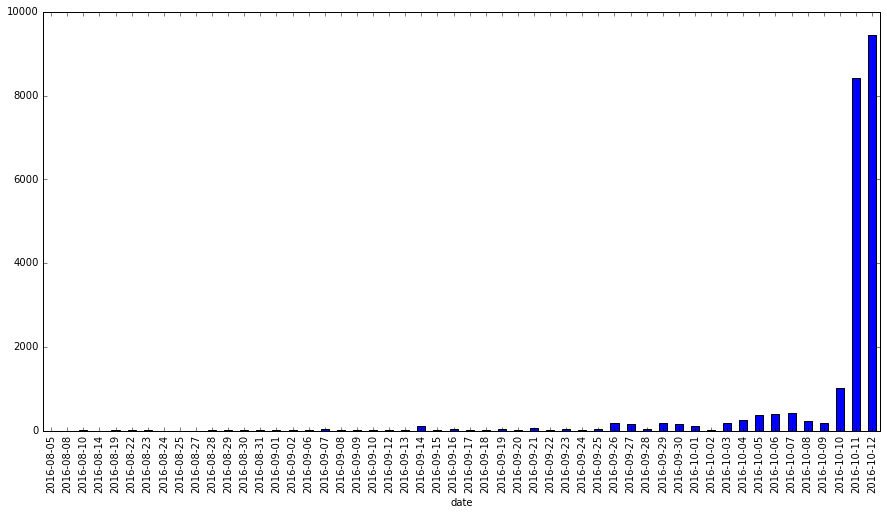

In [207]:
df["date"] = df["date"].astype(str)
counts = df.groupby("date")["date"].count()
counts.sort_index(ascending=True, inplace=True)
counts.plot(kind="bar");

In [208]:
df = clean_dataframe(df[df["date"]=="2016-10-12"])
df[["date","name","symbol","time","title","tweet_id","user_id","user_name"]].head()

,date,name,symbol,time,title,tweet_id,user_id,user_name
index,,,,,,,,
0,2016-10-12,Greg Feirman,FTNT,00:00:13,Fortinet Inc.,64514177,144909,TopGunFP
1,2016-10-12,Daily_Investor,SPY,00:01:41,SPDR S&P 500,64514225,569812,Daily_Investor
2,2016-10-12,Elliottwave Forecast,AAPL,00:01:45,Apple Inc.,64514227,128933,ElliottForecast
3,2016-10-12,Anhvu,DEPO,00:01:45,DepoMed Inc.,64514228,828087,Luck689
4,2016-10-12,Anhvu,ISIL,00:01:45,Intersil Corporation,64514228,828087,Luck689


In [209]:
network = nx.Graph()

#create a dictionary of {tweet_id : [symbols]}
dict1 = {}
rdf = df.groupby("tweet_id")
for tweet_id in list(set(df.tweet_id.values)):
    dict1[tweet_id] = list(rdf.get_group(tweet_id).symbol.values) 

#Create and save the weighted graph for use in Gephi
for key, value in dict1.items():
    for tup in list(itertools.combinations(value, 2)):        
        source = tup[0]
        target = tup[1] 
        if source != target:
            if network.has_edge(source, target) == True:            
                #network[source][target]["weight"] += 1
                pass
            else:
                date = df["date"][df["tweet_id"]==key].values[0]
                network.add_nodes_from([source, target])
                network.add_edge(source, target, weight=1, key=str(key), date=str(date))

In [210]:
N = len(network)
L = network.size()
degrees = list(network.degree().values())
kmin = min(degrees)
kmax = max(degrees)

print("Number of nodes:", N)
print("Number of edges:", L)
print()
print("Minimum degree :", kmin)
print("Maximum degree :", kmax)
print()
print("Average degree :", np.mean(degrees))

Number of nodes: 494
Number of edges: 3150

Minimum degree : 1
Maximum degree : 140

Average degree : 12.7530364372


In [211]:
#Add node attributes 
nodes  = []
titles = {}
for node in network.nodes():
    titles[node] = df["title"][df.symbol==node].values[0]
    nodes.append({"name": node, "title": df["title"][df.symbol==node].values[0]})

nx.set_node_attributes(network, "Title", titles)
nx.write_gexf(network, "symbol_graph.gexf")

In [212]:
#save the unweighted graph for use in R
data = []
node_list = list(network.nodes())

for (source, target) in network.edges():
    data.append({"value": 1.0, 
                 "id": network[source][target]["key"],
                 "date": network[source][target]["date"],
                 "source": node_list.index(source), 
                 "target": node_list.index(target)
                })    

links = pd.DataFrame(data)
nodes = pd.DataFrame(nodes)
links.to_csv("Rlinks.csv", index=False, encoding="utf-8")
nodes.to_csv("Rnodes.csv", index=False, encoding="utf-8")

In [213]:
#Get 10 logarithmically spaced bins between kmin and kmax
bin_edges = np.logspace(np.log10(kmin), np.log10(kmax), num=10)

#histogram the data into these bins
density, _ = np.histogram(degrees, bins=bin_edges, density=True)

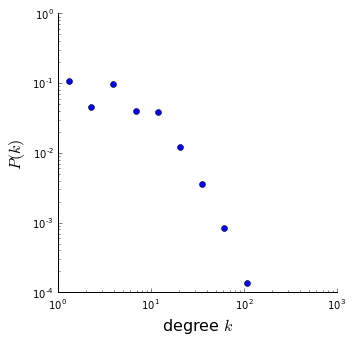

In [214]:
fig = plt.figure(figsize=(5, 5), dpi=100)

#"x" should be midpoint (IN LOG SPACE) of each bin
log_be = np.log10(bin_edges)
x = 10**((log_be[1:] + log_be[:-1])/2)

plt.loglog(x, density, marker='o', linestyle='none')
plt.xlabel(r"degree $k$", fontsize=16)
plt.ylabel(r"$P(k)$", fontsize=16)
#plt.xlim([0,1000])

#remove right and top boundaries because they're ugly
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

#Show the plot
plt.show()